In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
#Imports
import os
import tensorflow as tf
import numpy as np
import json
from PIL import Image
import time
from datetime import datetime
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#Global variables
TRAIN = True
finetuning = True
SEED = 1234
tf.random.set_seed(SEED)  
cwd = os.getcwd()
num_classes = 3
bs = 2
img_h = 1024
img_w = img_h
orig_img_h = 1536
orig_img_w = 2048

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Example: Image Segmentation
## Build segmentation

In [ ]:
# ImageDataGenerator
# ------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = True

# Create training ImageDataGenerator object
# We need two different generators for images and corresponding masks
if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(featurewise_center=True,
                                      featurewise_std_normalization=True,
                                      rotation_range=10,
                                      width_shift_range=10,
                                      height_shift_range=10,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')
    mask_data_gen = ImageDataGenerator(featurewise_center=True,
                                       featurewise_std_normalization=True,
                                       rotation_range=10,
                                       width_shift_range=10,
                                       height_shift_range=10,
                                       zoom_range=0.3,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='reflect')

In [ ]:
class CustomDataset(tf.keras.utils.Sequence):

  def __init__(self, dataset_dir, which_subset, preprocessing_function, img_generator=None, mask_generator=None, 
              out_shape=[img_h, img_w]):
    if which_subset == 'training':
      subset_file = os.path.join(dataset_dir, 'Splits', 'train.txt')
    elif which_subset == 'validation':
      subset_file = os.path.join(dataset_dir, 'Splits', 'val.txt')
    
    with open(subset_file, 'r') as f:
      lines = f.readlines()
    
    subset_filenames = []
    for line in lines:
      subset_filenames.append(line.strip()) 

    self.which_subset = which_subset
    self.dataset_dir = dataset_dir
    self.subset_filenames = subset_filenames
    self.img_generator = img_generator
    self.mask_generator = mask_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape

  def __len__(self):
    return len(self.subset_filenames)

  def _read_rgb_mask(self, img_path):
    '''
    img_path: path to the mask file
    Returns the numpy array containing target values
    '''

    mask_img = Image.open(img_path)
    mask_img = mask_img.resize(self.out_shape, resample=Image.NEAREST)
    mask_arr = np.array(mask_img)

    new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

    # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
    new_mask_arr[np.where(np.all(mask_arr == [216, 124, 18], axis=-1))] = 0 # border as bg
    new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
    new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2

    return new_mask_arr

  def __getitem__(self, index):
    # Read Image
    curr_filename = self.subset_filenames[index]
    img = Image.open(os.path.join(self.dataset_dir, 'Images', curr_filename + '.jpg'))

    # Resize image and mask
    img = img.resize(self.out_shape)
    
    img_arr = np.array(img)

    mask_arr = self._read_rgb_mask(os.path.join(self.dataset_dir, 'Masks', curr_filename + '.png'))

    mask_arr = np.expand_dims(mask_arr, -1)

    if self.which_subset == 'training':
      if self.img_generator is not None and self.mask_generator is not None:
        img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
        mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=SEED)
        img_arr = self.img_generator.apply_transform(img_arr, img_t)
        out_mask = np.zeros_like(mask_arr)
        for c in np.unique(mask_arr):
          if c > 0:
            curr_class_arr = np.float32(mask_arr == c)
            curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
            # from [0, 1] to {0, 1}
            curr_class_arr = np.uint8(curr_class_arr)
            # recover original class
            curr_class_arr = curr_class_arr * c 
            out_mask += curr_class_arr
    else:
      out_mask = mask_arr
    
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(img_arr)

    return img_arr, np.float32(out_mask)

In [ ]:
from tensorflow.keras.applications.vgg19 import preprocess_input 
#Applying VGG19 preprocess
dataset_dir = os.path.join(cwd, '/content/drive/MyDrive/ISTRUZIONE/Magistrale UNI/ARTIFICIAL_NN and Deep_Learning/Assignment_2/Dataset')
dataset_dir = os.path.join(dataset_dir, 'BipBip')

dataset = CustomDataset(dataset_dir, 'training', 
                        img_generator=img_data_gen, 
                        mask_generator=mask_data_gen,
                        preprocessing_function=preprocess_input)
dataset_valid = CustomDataset(dataset_dir, 'validation',
                              preprocessing_function=preprocess_input)


In [ ]:
#Train and Valid datasets
train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))
train_dataset = train_dataset.batch(bs)
train_dataset = train_dataset.repeat()


valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))
valid_dataset = valid_dataset.batch(bs)
valid_dataset = valid_dataset.repeat()

[0. 1. 2.]


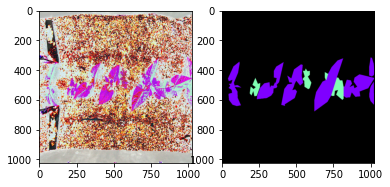

In [ ]:
### Test data generator
import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline

# Assign a color to each class
evenly_spaced_interval = np.linspace(0, 1, 3)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]

iterator = iter(valid_dataset)

fig, ax = plt.subplots(1, 2)

augmented_img, target = next(iterator)
augmented_img = augmented_img[0]   # First element
augmented_img = augmented_img  # denormalize

target = np.array(target[0, ..., 0])   # First element (squeezing channel dimension)

print(np.unique(target))

target_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, num_classes):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(augmented_img))
ax[1].imshow(np.uint8(target_img))

plt.show()

## Convolutional Neural Network (CNN)
### Encoder-Decoder

In [ ]:
vgg = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))

if finetuning:
    freeze_until = 1 # layer from fine-tuning
    for layer in vgg.layers[:freeze_until]:
        layer.trainable = False
    for layer in vgg.layers[freeze_until:]:
        layer.trainable = True
else:
    vgg.trainable = False

vgg.summary()

for layer in vgg.layers:
  print(layer.trainable)

In [ ]:
def create_model(depth, num_classes, start_f=256):

    model = tf.keras.Sequential()
    
    # Encoder
    # -------
    model.add(vgg)
        
    # Decoder
    # -------
    
    for i in range(depth):
        model.add(tf.keras.layers.UpSampling2D(2, interpolation='bilinear'))
        model.add(tf.keras.layers.Conv2D(filters=start_f,
                                         kernel_size=(3, 3),
                                         strides=(1, 1),
                                         padding='same'))
        model.add(tf.keras.layers.BatchNormalization());
        model.add(tf.keras.layers.ReLU())
        #model.add(tf.keras.layers.Dropout(0.2, seed=SEED))

        start_f = start_f // 2

    # Prediction Layer
    # ----------------
    model.add(tf.keras.layers.Conv2D(filters=num_classes,
                                     kernel_size=(1, 1),
                                     strides=(1, 1),
                                     padding='same',
                                     activation='softmax',
                                     name='output'))
    
    return model

In [ ]:
model = create_model(depth=5,
                     num_classes=num_classes)

# Visualize created model as a table
model.summary()

## Prepare the model for training

In [ ]:
# Optimization params
# -------------------

# Loss
# Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
loss = tf.keras.losses.SparseCategoricalCrossentropy() 
lr = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Here we define the intersection over union for each class in the batch.
# Then we compute the final iou as the mean over classes
def meanIoU(y_true, y_pred):
    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []
    weights = [0., 1., 2.]

    for i in range(1,num_classes): # exclude the background class 0
      # Get prediction and target related to only a single class (i)
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
      iou = weights[i] * (intersection + 1e-7) / (union + 1e-7)
      #iou = (intersection + 1e-7) / (union + 1e-7)
      per_class_iou.append(iou)

    return tf.reduce_sum(per_class_iou) / tf.reduce_sum(weights)
    #return tf.reduce_mean(per_class_iou)

# Validation metrics
# ------------------
metrics = ['accuracy', meanIoU]
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

## Training with callbacks

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir /content/drive/My\ Drive/Assignment_2/Log

In [ ]:
if(TRAIN):
  exps_dir = os.path.join(cwd, '/content/drive/MyDrive/ISTRUZIONE/Magistrale UNI/ARTIFICIAL_NN and Deep_Learning/Assignment_2', 'multiclass_segmentation_experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  model_name = 'CNN_Ars'

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                    save_weights_only=True, save_best_only=True)  # False to save the model directly
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                              profile_batch=0,
                                              histogram_freq=0)  # if 1 shows weights histograms
  callbacks.append(tb_callback)

  # Reduce on Plateu
  # --------------
  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1, cooldown=0)
  callbacks.append(reduce_lr)

  # Early Stopping
  # --------------
  early_stop = True
  if early_stop:
      es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
      callbacks.append(es_callback)




In [ ]:
  model.fit(x=train_dataset,
            epochs=50,  #### set repeat in training dataset
            steps_per_epoch=len(dataset),
            validation_data=valid_dataset,
            validation_steps=len(dataset_valid),#ceildiv(len(dataset_valid), bs), 
            callbacks=callbacks)

## Compute prediction

(1, 1024, 1024, 3)

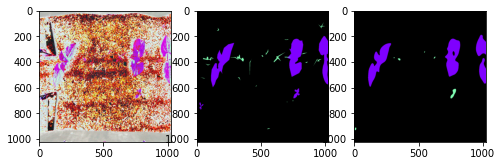

In [ ]:
#Testing visually accuracy of predicitons

fig, ax = plt.subplots(1, 3, figsize=(8, 8))
fig.show()
image, target = next(iterator)

image = image[0]
target = target[0, ..., 0]

out_sigmoid = model.predict(x=tf.expand_dims(image, 0))

# Get predicted class as the index corresponding to the maximum value in the vector probability
# predicted_class = tf.cast(out_sigmoid > score_th, tf.int32)
# predicted_class = predicted_class[0, ..., 0]
predicted_class = tf.argmax(out_sigmoid, -1)

out_sigmoid.shape

predicted_class = predicted_class[0, ...]

# Assign colors (just for visualization)
target_img = np.zeros([target.shape[0], target.shape[1], 3])
prediction_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, 3):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

prediction_img[np.where(predicted_class == 0)] = [0, 0, 0]
for i in range(1, 3):
  prediction_img[np.where(predicted_class == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(image))
ax[1].imshow(np.uint8(target_img))
ax[2].imshow(np.uint8(prediction_img))

fig.canvas.draw()

In [ ]:
def rle_encode(img):
    '''
    img: numpy array, 1 - foreground, 0 - background
    Returns run length as string formatted
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

################################################################################
################################################################################

import cv2
def update_dictionary(submission_dict, img, img_name, team, crop,):
  submission_dict[img_name] = {}
  submission_dict[img_name]['shape'] = img.shape
  submission_dict[img_name]['team'] = team
  submission_dict[img_name]['crop'] = crop
  submission_dict[img_name]['segmentation'] = {}

  # RLE encoding  
  # crop
  rle_encoded_crop = rle_encode(img == 1)
  # weed
  rle_encoded_weed = rle_encode(img == 2)

  submission_dict[img_name]['segmentation']['crop'] = rle_encoded_crop
  submission_dict[img_name]['segmentation']['weed'] = rle_encoded_weed
  # Finally, save the results into the submission.json file
  return submission_dict

################################################################################
################################################################################

def trim_filenames(test_gen):
  filenames = test_gen.filenames
  prova = [e[7:] for e in filenames]
  filenames = []
  for file in prova:
    filenames.append(file.split(".")[0])
  return filenames

################################################################################
################################################################################

def create_prediction(category, dictionary):
  team = category.split('/')[0]
  crop = category.split('/')[1]
  path = os.path.join(cwd, '//content/drive/MyDrive/ISTRUZIONE/Magistrale UNI/ARTIFICIAL_NN and Deep_Learning/Assignment_2/Dataset/All/Test_Dev', category)
  print(path)
  test_data_gen = ImageDataGenerator()
  test_gen = test_data_gen.flow_from_directory(path,
                                               target_size=(img_h,img_w),
                                               color_mode="rgb",
                                               batch_size=1, 
                                               class_mode='categorical',
                                               classes=None,
                                               shuffle=False,
                                               seed=SEED)
  
  filenames = trim_filenames(test_gen)
  prediction = model.predict(test_gen)
  for i in range(len(filenames)):
    arr_ = np.squeeze(prediction[i])
    resize_img = cv2.resize(arr_, dsize=(orig_img_w, orig_img_h), interpolation=cv2.INTER_NEAREST)
    predicted_class = tf.argmax(resize_img, -1)
    result = np.array(predicted_class)
    dictionary = update_dictionary(dictionary, result, filenames[i], team, crop)
    #create_json(result, filenames[i], team, crop, os.path.join(cwd, 'drive/MyDrive/ANN/submission.json'))
  
  return dictionary


################################################################################
################################################################################


def iterate_dataset(directories_path):
  with open(directories_path, 'r') as f:
    paths = [line.rstrip() for line in f.readlines()]
    dictionary = {}
    for name in paths:
      dictionary = create_prediction(name, dictionary)
    with open(os.path.join(cwd, '/content/drive/MyDrive/ISTRUZIONE/Magistrale UNI/ARTIFICIAL_NN and Deep_Learning/Assignment_2/submission.json'), 'w') as f:
      json.dump(dictionary, f)

In [ ]:
iterate_dataset(os.path.join(cwd, '/content/drive/MyDrive/ISTRUZIONE/Magistrale UNI/ARTIFICIAL_NN and Deep_Learning/Assignment_2/directories.txt'))

## Zipping file

In [ ]:
%cd drive/MyDrive/Assignment_2/Results/

In [ ]:
from zipfile import ZipFile

with ZipFile('submission.zip', 'w') as zipObj:
  zipObj.write('submission.json')

In [ ]:
# resetting workign directory
%cd /content/